# 3. Napovedovanje aktivnosti struktur na naboru naključnih molekul

In [1]:
%run __A_knjiznice.py

# Import specific elements from the script
from __A_knjiznice import *
from __B_funkcije import *

In [2]:
directory = '/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir1/podatki_napoved'
filepath_train_data = '/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir1/molekulski_prstni_odtisi/df_rdkit.csv'

# Pridobitev naključnih struktur

In [3]:
import polars as pl
import numpy as np
import gc  # Garbage collector
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile, chi2, VarianceThreshold
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

# Step 1: Read datasets using Polars
df = pl.read_csv('/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir1/podatki_napoved/df_with_fingerprints_rdk_all.csv')
df_train = pl.read_csv(filepath_train_data)

# Step 2: Extract unique SMILES from the training dataset
trained_smiles = set(df_train['Smiles'].to_list())

# Step 3: Filter rows not present in the training dataset
df_filtered = df.filter(~pl.col('Smiles').is_in(trained_smiles))

# Calculate the count of matches excluded
matches_count = df.shape[0] - df_filtered.shape[0]
print(f'Number of matches excluded: {matches_count}')

Number of matches excluded: 101


In [4]:
# Step 4: Prepare target variable (y) and features (X)
y = df_train['Activity'].to_numpy()
X = df_train[:, 3:].to_numpy()

# Step 5: Define Random Forest parameters
rf_params = {
    'n_estimators': 125,
    'max_depth': 18,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'n_jobs': -1,
    'random_state': 42
}

# Step 6: Build the pipeline
steps = [
    ('variance_threshold', VarianceThreshold()),
    ('feature_selection', SelectPercentile(score_func=chi2, percentile=35)),
    ('classifier', RandomForestClassifier(**rf_params))
]

pipeline = Pipeline(steps)
pipeline.fit(X, y)

# Step 7: Batch Predictions
batch_size = 500_000  # Process data in manageable chunks
smiles_list = []
predicted_activities = []
predicted_probabilities = []

print("Starting batch predictions...")
for batch_start in range(0, len(df_filtered), batch_size):
    batch_end = min(batch_start + batch_size, len(df_filtered))
    print(f"Processing batch {batch_start} to {batch_end}")
    
    batch_data = df_filtered.slice(batch_start, batch_size)
    smiles_batch = batch_data['Smiles'].to_list()
    X_molport = batch_data[:, 2:].to_numpy()
    
    # Predict batch
    y_pred = pipeline.predict(X_molport)
    y_proba = pipeline.predict_proba(X_molport)[:, 1]
    
    smiles_list.extend(smiles_batch)
    predicted_activities.extend(y_pred)
    predicted_probabilities.extend(y_proba)
    
    # Explicit memory cleanup
    del X_molport, y_pred, y_proba, smiles_batch
    gc.collect()

# Step 8: Create a results DataFrame
results_df = pl.DataFrame({
    'Smiles': smiles_list,
    'Predicted_Activity': predicted_activities,
    'Probability_Active': predicted_probabilities
})
results_df

Starting batch predictions...
Processing batch 0 to 500000
Processing batch 500000 to 1000000
Processing batch 1000000 to 1500000
Processing batch 1500000 to 2000000
Processing batch 2000000 to 2500000
Processing batch 2500000 to 3000000
Processing batch 3000000 to 3500000
Processing batch 3500000 to 4000000
Processing batch 4000000 to 4500000
Processing batch 4500000 to 5000000
Processing batch 5000000 to 5318843


Smiles,Predicted_Activity,Probability_Active
str,i64,f64
"""COc1cc(ccc1O)C(C)=O""",0,0.045385
"""CC(=O)c1ncccc1N""",0,0.069691
"""C=CCOc1ccccc1C=O""",0,0.0538
"""Oc1c(CC=C)cccc1C=O""",0,0.056594
"""Nc1cnc(Br)cn1""",0,0.078187
…,…,…
"""[NaH].[2H]c1c([2H])c([2H])c(c(…",0,0.165928
"""[2H]C([2H])(OC(=O)c1ccc(C(=O)O…",0,0.275381
"""Nc1ncnc2n(cnc12)[C@H]1C[C@H](O…",0,0.406808


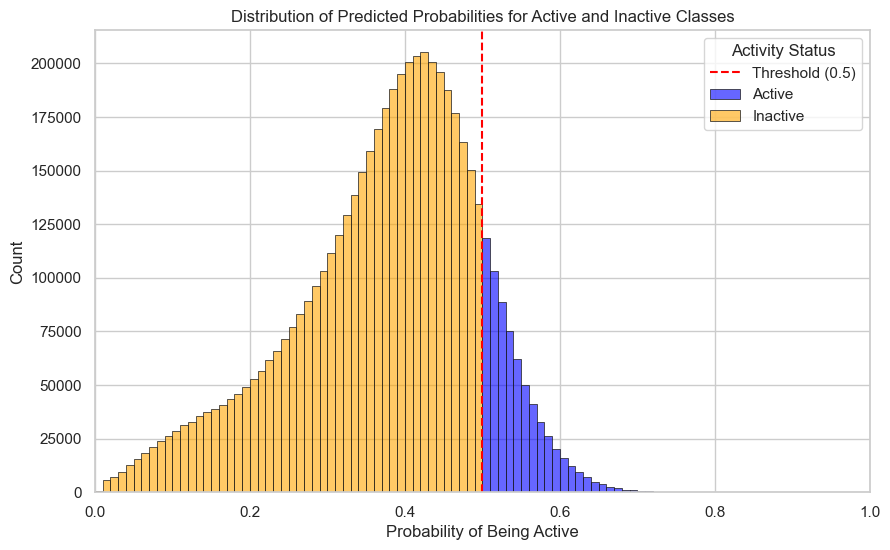

In [5]:
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Add the Activity_Status column using Polars
results_df = results_df.with_columns(
    pl.when(pl.col('Probability_Active') > 0.5)
    .then(pl.lit('Active'))
    .otherwise(pl.lit('Inactive'))
    .alias('Activity_Status')
)

# Convert to Pandas for plotting
result_df = results_df.to_pandas()

# Set the style of seaborn
sns.set(style="whitegrid")

# Create the figure
plt.figure(figsize=(10, 6))

# Define bins for 1% increments from 0 to 1
bins = np.arange(0, 1.01, 0.01)  # 0 to 1 in steps of 0.01

# Create the histogram for Active substances
sns.histplot(data=result_df[result_df['Activity_Status'] == 'Active'], 
             x='Probability_Active', bins=bins, 
             color='blue', stat='count', edgecolor='k', label='Active', alpha=0.6)

# Create the histogram for Inactive substances
sns.histplot(data=result_df[result_df['Activity_Status'] == 'Inactive'], 
             x='Probability_Active', bins=bins, 
             color='orange', stat='count', edgecolor='k', label='Inactive', alpha=0.6)

# Add a vertical line at the 0.5 threshold for clarity
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')

# Add labels and title
plt.title('Distribution of Predicted Probabilities for Active and Inactive Classes')
plt.xlabel('Probability of Being Active')
plt.ylabel('Count')
plt.xlim(0, 1)  # Set x-axis limits from 0 to 1
plt.grid(True)
plt.legend(title='Activity Status')

# Show the plot
plt.show()

In [6]:
# Define thresholds
thresholds = [0.5, 0.75, 0.9]

# Initialize a dictionary to store counts
active_counts = {}

for threshold in thresholds:
    # Filter rows where Probability_Active is above the threshold
    filtered_df = results_df.filter(pl.col('Probability_Active') > threshold)
    
    # Get the count of active predictions (Predicted_Activity == 1)
    count_active = filtered_df.filter(pl.col('Predicted_Activity') == 1).shape[0]
    
    # Store the result in the dictionary
    active_counts[f'Count_Active_Above_{int(threshold * 100)}%'] = count_active

# Convert the dictionary to a Polars DataFrame
active_counts_df = pl.DataFrame(active_counts)

# Display the counts
print(active_counts_df)

shape: (1, 3)
┌────────────────────────┬────────────────────────┬────────────────────────┐
│ Count_Active_Above_50% ┆ Count_Active_Above_75% ┆ Count_Active_Above_90% │
│ ---                    ┆ ---                    ┆ ---                    │
│ i64                    ┆ i64                    ┆ i64                    │
╞════════════════════════╪════════════════════════╪════════════════════════╡
│ 679184                 ┆ 229                    ┆ 10                     │
└────────────────────────┴────────────────────────┴────────────────────────┘


In [7]:
# # Filter for active predictions (Predicted_Activity == 1) and sort by Probability_Active in descending order
# active_results = df_molport[df_molport['Predicted_Activity'] == 1].sort_values(by='Probability_Active', ascending=False)
# active_results
# Filter for active predictions (Predicted_Activity == 1) and sort by Probability_Active in descending order
active_results = result_df[result_df['Predicted_Activity'] == 1].sort_values(by='Probability_Active', ascending=False)
active_results

,Smiles,Predicted_Activity,Probability_Active,Activity_Status
5006765,C[C@@H](NC(=O)c1ccc(Cl)cc1)[C@H]1CC[C@H](CC1)c...,1,0.970152,Active
4089449,NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N\O,1,0.950978,Active
4325970,NS(=O)(=O)NCCNc1nonc1C(Nc1ccc(F)c(Br)c1)=NO,1,0.950978,Active
4113221,NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O,1,0.950978,Active
4459106,NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O,1,0.948135,Active
...,...,...,...,...
2221496,COc1ccc(cc1)-c1cc(CN(CC2CCCO2)C(=O)c2ccco2)no1,1,0.500000,Active
3127042,CC(C)n1nnc2cc(ccc12)S(=O)(=O)N1CCCC1C(=O)NCc1c...,1,0.500000,Active
1810204,CCCCCN1C(=O)C2(NC(=O)c3ccccc3N2)c2ccccc12,1,0.500000,Active
3115650,CCOC(=O)C1CCN(CC1)C(=O)C1CCc2nc(sc2C1)N1CCN(CC...,1,0.500000,Active


In [8]:
active_results.head(100)

,Smiles,Predicted_Activity,Probability_Active,Activity_Status
5006765,C[C@@H](NC(=O)c1ccc(Cl)cc1)[C@H]1CC[C@H](CC1)c...,1,0.970152,Active
4089449,NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N\O,1,0.950978,Active
4325970,NS(=O)(=O)NCCNc1nonc1C(Nc1ccc(F)c(Br)c1)=NO,1,0.950978,Active
4113221,NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O,1,0.950978,Active
4459106,NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O,1,0.948135,Active
...,...,...,...,...
1437900,COC(=O)C(NC(=O)c1ccc(Cl)cc1)C12CC3CC(CC(C3)C1)C2,1,0.771732,Active
2216218,CC(C)C(C)N(Cc1cc(NC(=O)C2CCC2)ccc1N(C)C)C(=O)c...,1,0.771451,Active
586825,OC(=O)C1CCCCC1C(=O)Nc1ccc(Br)cc1F,1,0.771433,Active
1966321,Fc1ccc(NC(=O)C2CC22CCN(Cc3ccccc3)CC2)cc1F,1,0.770661,Active


In [9]:
most_active = active_results.iloc[:2500].copy()
most_active

,Smiles,Predicted_Activity,Probability_Active,Activity_Status
5006765,C[C@@H](NC(=O)c1ccc(Cl)cc1)[C@H]1CC[C@H](CC1)c...,1,0.970152,Active
4089449,NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N\O,1,0.950978,Active
4325970,NS(=O)(=O)NCCNc1nonc1C(Nc1ccc(F)c(Br)c1)=NO,1,0.950978,Active
4113221,NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O,1,0.950978,Active
4459106,NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O,1,0.948135,Active
...,...,...,...,...
5212848,Fc1ccc(cc1)N1CCCC2(CCN(CC2)C(=O)CCc2ccccc2)C1=O,1,0.693031,Active
2222619,CC(C)(C)NC(=O)N1CCN(CC1)c1ccc(NC(=O)C2CCCC2)cc...,1,0.693009,Active
3044014,CC(C)CC(=O)N1CCc2cc(CNC(=O)c3cccc(Cl)c3)ccc12,1,0.693000,Active
5208534,Cc1nccn1Cc1cccc(c1)C(=O)N1CCCC2(CN(C(=O)O2)c2c...,1,0.692996,Active


In [10]:
from rdkit import Chem
from rdkit.Chem import FilterCatalog

def is_pains(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return 0  # Return 0 if the SMILES string is invalid
    
    # Initialize PAINS filter catalog
    params = FilterCatalogParams()
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_A)
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_B)
    params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_C)
    catalog = FilterCatalog.FilterCatalog(params)  # Correct instantiation
    
    # Check for PAINS
    entry = catalog.GetFirstMatch(mol)
    return 1 if entry is not None else 0

# Apply the PAINS filter function to the 'Smiles' column
most_active['is_pains'] = most_active['Smiles'].apply(is_pains)

# Filter out PAINS molecules
df_filtered_1 = most_active[most_active['is_pains'] == 0].drop(columns=['is_pains'])

# most_active_filtered = df_filtered_1[['Smiles', 'MOLPORTID', 'Predicted_Activity', 'Probability_Active']].copy()
most_active_filtered = df_filtered_1[['Smiles', 'Predicted_Activity', 'Probability_Active']].copy()
most_active_filtered

,Smiles,Predicted_Activity,Probability_Active
5006765,C[C@@H](NC(=O)c1ccc(Cl)cc1)[C@H]1CC[C@H](CC1)c...,1,0.970152
4089449,NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N\O,1,0.950978
4325970,NS(=O)(=O)NCCNc1nonc1C(Nc1ccc(F)c(Br)c1)=NO,1,0.950978
4113221,NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O,1,0.950978
4459106,NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O,1,0.948135
...,...,...,...
4373068,CC1(C)CC1(C(=O)Nc1ccc(CC(=O)NC2CC2)cc1)c1ccc(F...,1,0.693036
5212848,Fc1ccc(cc1)N1CCCC2(CCN(CC2)C(=O)CCc2ccccc2)C1=O,1,0.693031
3044014,CC(C)CC(=O)N1CCc2cc(CNC(=O)c3cccc(Cl)c3)ccc12,1,0.693000
5208534,Cc1nccn1Cc1cccc(c1)C(=O)N1CCCC2(CN(C(=O)O2)c2c...,1,0.692996


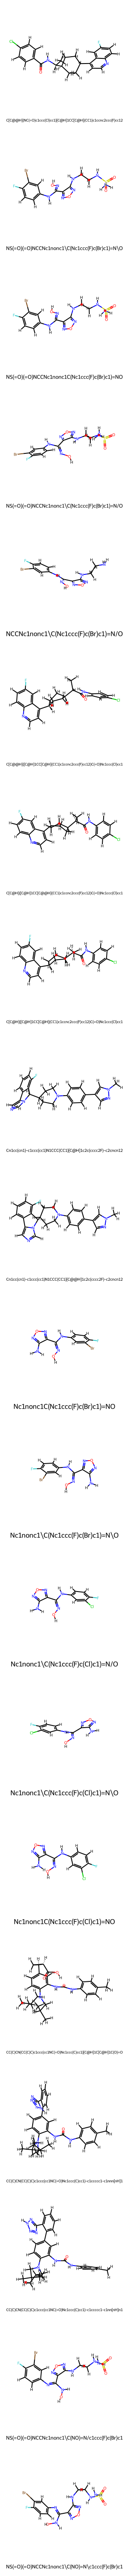

In [11]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# Select the first five SMILES and convert to a list
smiles_list = most_active_filtered['Smiles'].head(20).tolist()

# Convert SMILES to RDKit Mol objects and generate 3D structures
molecules = []
for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        # Add hydrogens
        mol = Chem.AddHs(mol)
        # Generate 3D coordinates
        AllChem.EmbedMolecule(mol, randomSeed=0xf00d)
        AllChem.UFFOptimizeMolecule(mol)
        molecules.append(mol)

# Draw the molecules with SMILES as labels in separate rows
img = Draw.MolsToGridImage(molecules, molsPerRow=1, subImgSize=(300, 300), legends=smiles_list)

# Display the image
img

In [12]:
# Print out the first 20 SMILES
print("First 20 SMILES:")
for smiles in smiles_list:
    print(smiles)

First 20 SMILES:
C[C@@H](NC(=O)c1ccc(Cl)cc1)[C@H]1CC[C@H](CC1)c1ccnc2ccc(F)cc12
NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N\O
NS(=O)(=O)NCCNc1nonc1C(Nc1ccc(F)c(Br)c1)=NO
NS(=O)(=O)NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O
NCCNc1nonc1\C(Nc1ccc(F)c(Br)c1)=N/O
C[C@@H]([C@H]1CC[C@H](CC1)c1ccnc2ccc(F)cc12)C(=O)Nc1ccc(Cl)cc1
C[C@H]([C@H]1CC[C@@H](CC1)c1ccnc2ccc(F)cc12)C(=O)Nc1ccc(Cl)cc1
C[C@H]([C@H]1CC[C@H](CC1)c1ccnc2ccc(F)cc12)C(=O)Nc1ccc(Cl)cc1
Cn1cc(cn1)-c1ccc(cc1)N1CCC(CC1)[C@H]1c2c(cccc2F)-c2cncn12
Cn1cc(cn1)-c1ccc(cc1)N1CCC(CC1)[C@@H]1c2c(cccc2F)-c2cncn12
Nc1nonc1C(Nc1ccc(F)c(Br)c1)=NO
Nc1nonc1\C(Nc1ccc(F)c(Br)c1)=N\O
Nc1nonc1\C(Nc1ccc(F)c(Cl)c1)=N/O
Nc1nonc1\C(Nc1ccc(F)c(Cl)c1)=N\O
Nc1nonc1C(Nc1ccc(F)c(Cl)c1)=NO
CC(C)CN(CC(C)C)c1ccc(cc1NC(=O)Nc1ccc(C)cc1)[C@H]1C[C@H]1C(O)=O
CC(C)CN(CC(C)C)c1ccc(cc1NC(=O)Nc1ccc(C)cc1)-c1ccccc1-c1nnn[nH]1
CC(C)CN(CC(C)C)c1ccc(cc1NC(=O)Nc1ccc(C)cc1)-c1ccccc1-c1nn[nH]n1
NS(=O)(=O)NCCNc1nonc1\C(NO)=N/c1ccc(F)c(Br)c1
NS(=O)(=O)NCCNc1nonc1\C(NO)=N\c1ccc(F)c(Br)c1

In [13]:
df_filtered_1.to_csv('/Users/samonose/PycharmProjects/IDO_inhibitors_ML_predictions/dir2/podatki_napoved/most_active_filtered_rf_all.csv', index=False)